# Урок 3. Dataset, Dataloader, BatchNorm, Dropout, Оптимизация

Будем практиковаться на датасете:
https://www.kaggle.com/c/avito-demand-prediction

Ваша задача:
1. Создать Dataset для загрузки данных (используем только числовые данные)
2. Обернуть его в Dataloader
3. Написать архитектуру сети, которая предсказывает число показов на основании числовых данных (вы всегда можете нагенерить дополнительных факторов). Сеть должна включать BatchNorm слои и Dropout (или НЕ включать, но нужно обосновать)
4. Учить будем на функцию потерь с кагла (log RMSE) - нужно её реализовать
5. Сравните сходимость Adam, RMSProp и SGD, сделайте вывод по качеству работы модели

train-test разделение нужно сделать с помощью sklearn random_state=13, test_size = 0.25

In [1]:
import numpy as np
import pandas as pd
import torch
import torchmetrics
import torch.nn as nn
import torch.nn.functional as F

from matplotlib import pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from torchvision import transforms

In [2]:
housing = fetch_california_housing(data_home=None, download_if_missing=True,
                              return_X_y=False, as_frame=True)
df = housing['frame']
df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [3]:
target = housing['target_names'][0]
feature_list = housing['feature_names']

In [4]:
X = df[feature_list]
y = df[target]

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=21)

In [6]:
scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

X_train = torch.FloatTensor(X_train).float()
X_test = torch.FloatTensor(X_test).float()

y_train = torch.FloatTensor(y_train.values).float()
y_test = torch.FloatTensor(y_test.values).float()

In [7]:
class MyDataset(torch.utils.data.Dataset):
    
    def __init__(self, X_data, y_data):
        self._X = X_data
        self._y = y_data
        
    def __len__(self):
        return len(self._X)
    
    def __getitem__(self, idx):
        X = self._X[idx]
        y = self._y[idx]
        return X, y

In [8]:
train_dataset = MyDataset(X_train, y_train)
test_dataset = MyDataset(X_test, y_test)

### Построение нейронной сети

In [9]:
class Perceptron(nn.Module):
    def __init__(self, input_dim, output_dim, activation="relu"):
        super(Perceptron, self).__init__()
        self.fc = nn.Linear(input_dim, output_dim)
        self.activation = activation
        
    def forward(self, x):
        x = self.fc(x)
        if self.activation=="relu":
            return F.relu(x)
        if self.activation=="sigmoid":
            return F.sigmoid(x)
        raise RuntimeError
        

class FeedForward(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(FeedForward, self).__init__()
        self.bn1 = nn.BatchNorm1d(input_dim)
        self.fc1 = Perceptron(input_dim, 2*hidden_dim)
        self.dp1 = nn.Dropout(0.25)
        self.bn2 = nn.BatchNorm1d(2*hidden_dim)
        self.fc2 = Perceptron(2*hidden_dim, hidden_dim)
        self.dp2 = nn.Dropout(0.2)
        self.bn3 = nn.BatchNorm1d(hidden_dim)
        self.fc3 = Perceptron(hidden_dim, 1)
        
    def forward(self, x):
        x = self.bn1(x)
        x = self.fc1(x)
        x = self.dp1(x)
        x = self.bn2(x)
        x = self.fc2(x)
        x = self.dp2(x)
        x = self.bn3(x)
        x = self.fc3(x)

        return x

In [10]:
net = FeedForward(8, 400)
optimizer = torch.optim.RMSprop(net.parameters(), lr=0.001)

In [11]:
def try_model(model, optimizer, num_epoches, train_dataset, test_dataset, silent=False):
    
    print('Оптимизатор:', type(optimizer).__name__, 'число эпох:', num_epoches)
    print(50*'-')
    
    train_loader = torch.utils.data.DataLoader(train_dataset,
                                          batch_size=128,
                                          shuffle=True,
                                          drop_last=True,
                                          num_workers=0)
    
    test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=8,
                                          shuffle=True,
                                          drop_last=True,
                                          num_workers=0)
    
    criterion = nn.MSELoss(reduction='sum')
    
    train_r2 = torchmetrics.R2Score()
    test_r2 = torchmetrics.R2Score()
    
    optimizer.zero_grad()
    
    model.train()

    for epoch in range(num_epoches):  

        running_loss, running_items = 0.0, 0.0

        for i, data in enumerate(train_loader):
            inputs, target = data[0], data[1]

            # обнуляем градиент
            optimizer.zero_grad()

            outputs = model(inputs)
            train_r2(outputs.squeeze(), target)
            loss = criterion(outputs.squeeze(), target)
            loss.backward()
            optimizer.step()

            # выводим статистику о процессе обучения
            running_loss += loss.item()
            running_items += len(target)

            if i % 60 == 0 and silent != True:
                model.eval()

                print(f'Epoch [{epoch+1}/{num_epoches}]. '\
                      f'Step [{i+1}/{len(train_loader)}]. '\
                      f'Loss: {running_loss/running_items:.3f}, ', \
                      f'r2_train: {train_r2.compute().item():.3f}, ', end=' ')

                running_loss, running_items = 0.0, 0.0
                train_r2.reset()

                for i, data in enumerate(test_loader):
                    test_outputs = model(data[0])
                    test_r2(test_outputs.squeeze(), data[1])

                print(f'r2_val: {test_r2.compute():.3f}')
                test_r2.reset()
                model.train()

    print('Training is finished!')
    print()
    
    model.eval()
    final_train = train_r2.compute().item()
    
    for i, data in enumerate(test_loader):
        test_outputs = model(data[0])
        test_r2(test_outputs.squeeze(), data[1])
    final_val = test_r2.compute().item()
    
    train_r2.reset()
    test_r2.reset()

    return round(final_train, 4), round(final_val, 4)

In [12]:
r2_train, r2_val = try_model(net, optimizer, 10, train_dataset, test_dataset)

Оптимизатор: RMSprop число эпох: 10
--------------------------------------------------
Epoch [1/10]. Step [1/120]. Loss: 5.212,  r2_train: -2.811,  r2_val: -2.376
Epoch [1/10]. Step [61/120]. Loss: 1.312,  r2_train: 0.015,  r2_val: 0.338
Epoch [2/10]. Step [1/120]. Loss: 0.508,  r2_train: 0.431,  r2_val: -0.883
Epoch [2/10]. Step [61/120]. Loss: 0.614,  r2_train: 0.529,  r2_val: 0.150
Epoch [3/10]. Step [1/120]. Loss: 0.456,  r2_train: 0.563,  r2_val: 0.362
Epoch [3/10]. Step [61/120]. Loss: 0.548,  r2_train: 0.589,  r2_val: 0.493
Epoch [4/10]. Step [1/120]. Loss: 0.521,  r2_train: 0.634,  r2_val: 0.491
Epoch [4/10]. Step [61/120]. Loss: 0.482,  r2_train: 0.638,  r2_val: 0.456
Epoch [5/10]. Step [1/120]. Loss: 0.964,  r2_train: 0.638,  r2_val: 0.380
Epoch [5/10]. Step [61/120]. Loss: 0.453,  r2_train: 0.657,  r2_val: 0.453
Epoch [6/10]. Step [1/120]. Loss: 0.372,  r2_train: 0.671,  r2_val: 0.488
Epoch [6/10]. Step [61/120]. Loss: 0.432,  r2_train: 0.669,  r2_val: 0.542
Epoch [7/10]. St

In [13]:
print(r2_train, r2_val)

0.7119 0.4806


## Тестируем разные параметры обучения

In [14]:
results = []

# Adam
for num_epoches in [5,10,20,30]:
    model = FeedForward(8, 400)
    parameters = model.parameters()
    optimizer = torch.optim.Adam(parameters, lr=0.001) 
    now = {}
    now['optimizer'] = type(optimizer).__name__
    now['epoches'] = num_epoches
    now['r2_train'], now['r2_val'] = try_model(model, optimizer, num_epoches, train_dataset, test_dataset, silent=True)
    results.append(now)
        
# RMSprop
for num_epoches in [5,10,20,30]:
    model = FeedForward(8, 400)
    parameters = model.parameters()
    optimizer = torch.optim.RMSprop(parameters, lr=0.001)
    now = {}
    now['optimizer'] = type(optimizer).__name__
    now['epoches'] = num_epoches
    now['r2_train'], now['r2_val'] = try_model(model, optimizer, num_epoches, train_dataset, test_dataset, silent=True)
    results.append(now)        

# SGD
for num_epoches in [5,10,20,30]:
    model = FeedForward(8, 400)
    parameters = model.parameters()
    optimizer = torch.optim.SGD(parameters, lr=0.001)
    now = {}
    now['optimizer'] = type(optimizer).__name__
    now['epoches'] = num_epoches
    now['r2_train'], now['r2_val'] = try_model(model, optimizer, num_epoches, train_dataset, test_dataset, silent=True)
    results.append(now) 

Оптимизатор: Adam число эпох: 5
--------------------------------------------------
Training is finished!

Оптимизатор: Adam число эпох: 10
--------------------------------------------------
Training is finished!

Оптимизатор: Adam число эпох: 20
--------------------------------------------------
Training is finished!

Оптимизатор: Adam число эпох: 30
--------------------------------------------------
Training is finished!

Оптимизатор: RMSprop число эпох: 5
--------------------------------------------------
Training is finished!

Оптимизатор: RMSprop число эпох: 10
--------------------------------------------------
Training is finished!

Оптимизатор: RMSprop число эпох: 20
--------------------------------------------------
Training is finished!

Оптимизатор: RMSprop число эпох: 30
--------------------------------------------------
Training is finished!

Оптимизатор: SGD число эпох: 5
--------------------------------------------------
Training is finished!

Оптимизатор: SGD число эпох: 

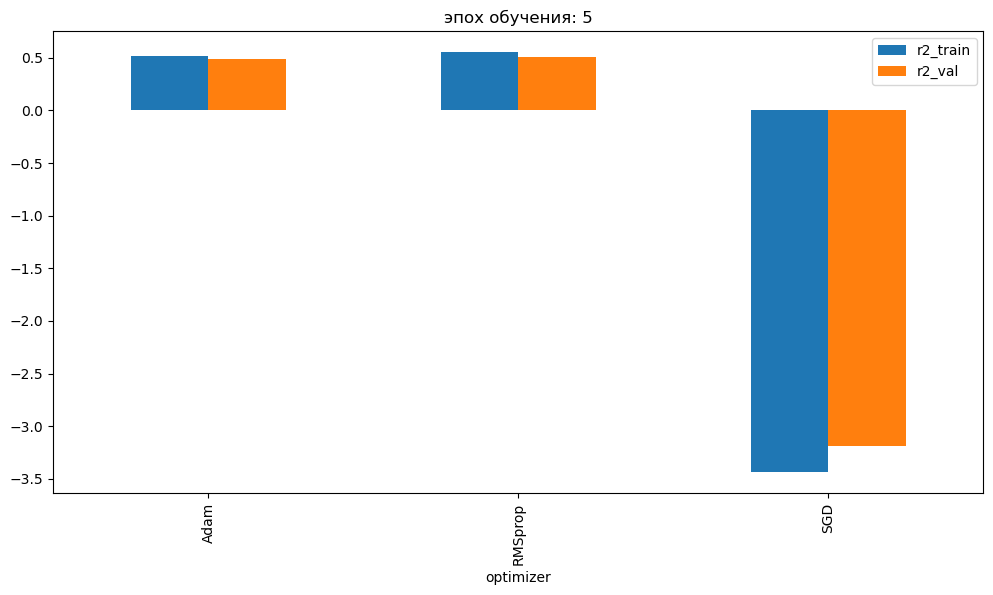

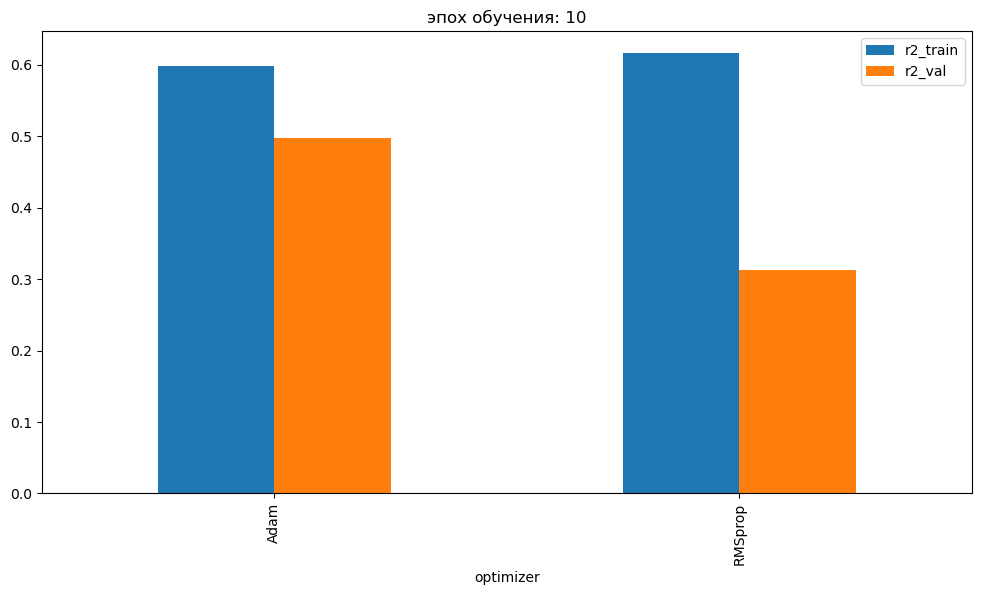

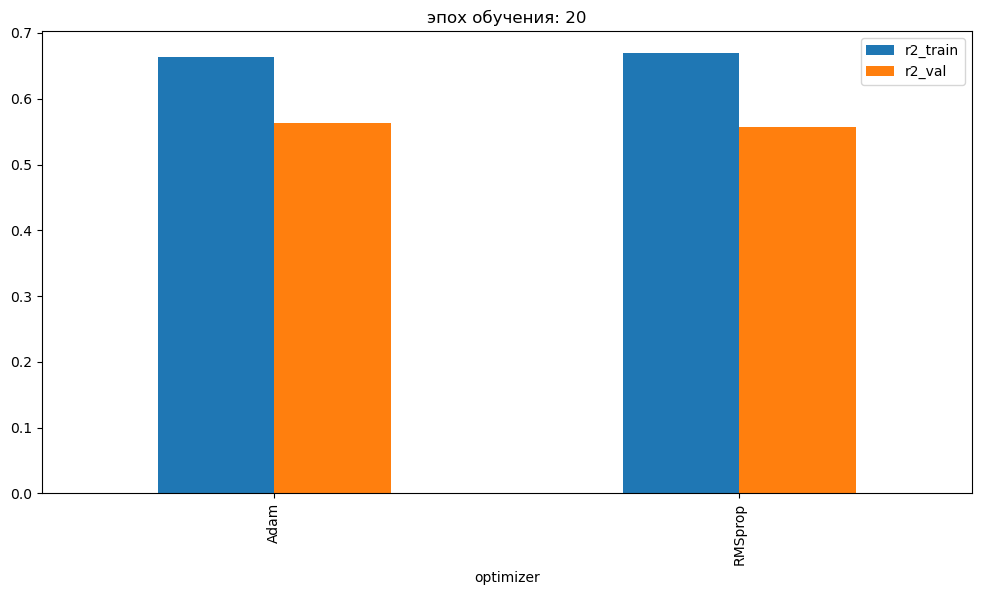

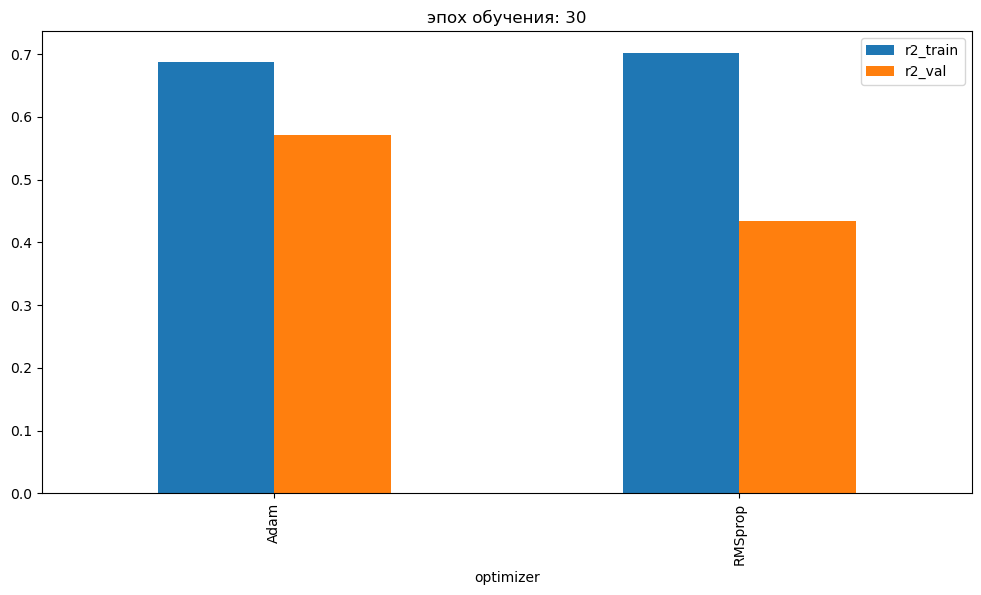

In [15]:
results = pd.DataFrame(results)

for i in results['epoches'].unique().tolist():
    title = 'эпох обучения: ' + str(i)
    pd.pivot_table(results.loc[results['epoches'] == i][['optimizer', 'r2_train', 'r2_val']],
                   index=['optimizer']).plot(kind='bar', title=title, figsize=(12,6))
    plt.show()

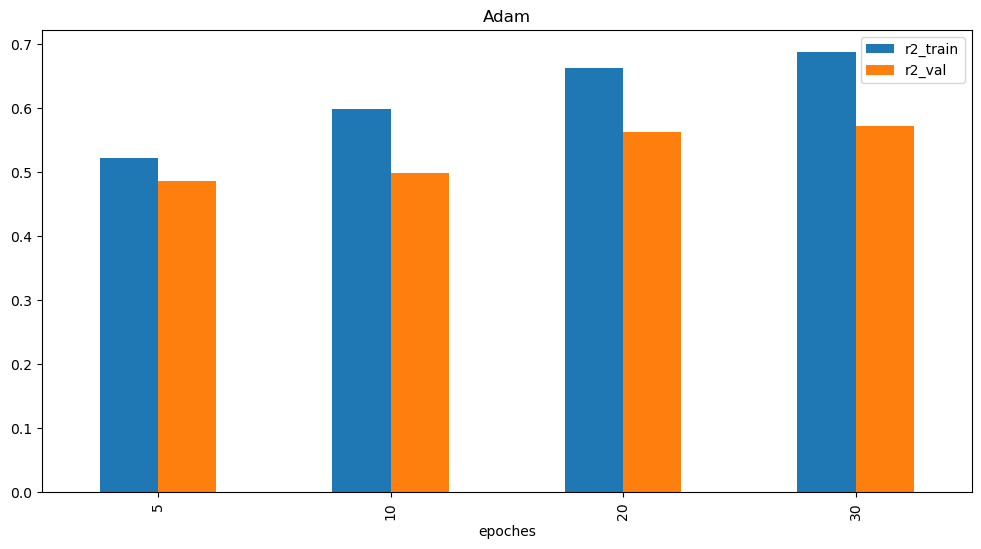

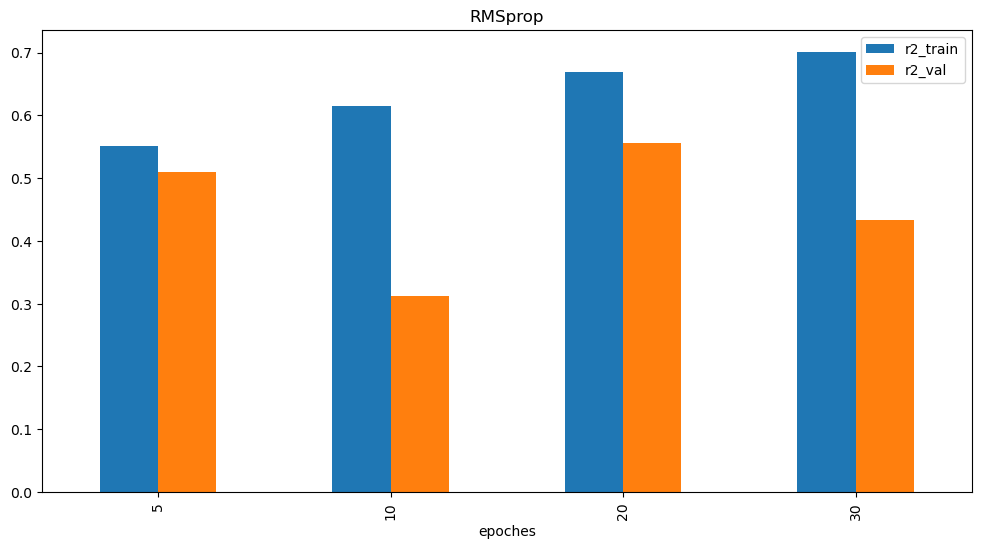

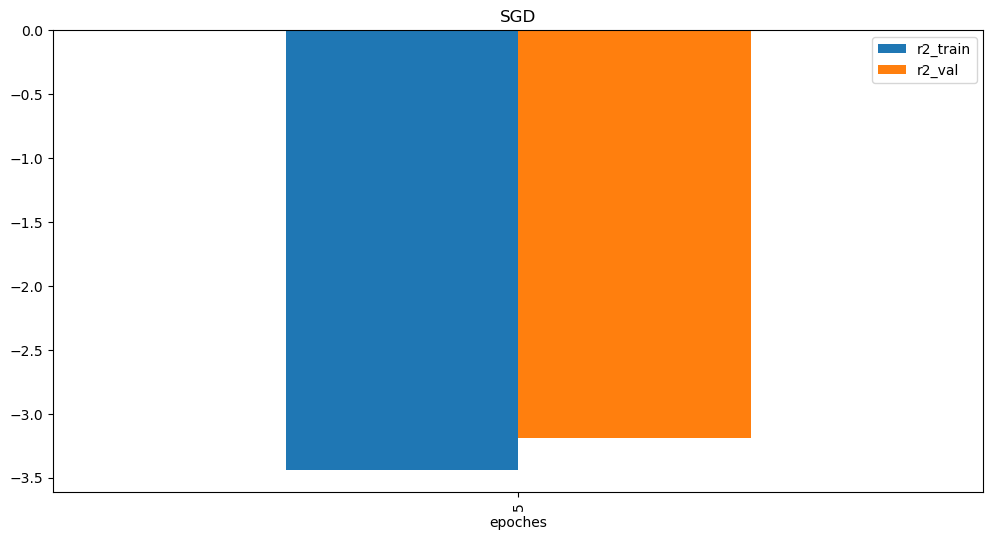

In [16]:
for o in results['optimizer'].unique().tolist():
    pd.pivot_table(results.loc[results['optimizer'] == o][['epoches', 'r2_train', 'r2_val']],
                   index=['epoches']).plot(kind='bar', figsize=(12,6), title=o)
    plt.show()

Вывод: очень странный результат показад оптимизатор SGD. Лучше всего в тесте отработал Adam. К тому же качество с ним в данном тесте расло пропорционально числу эпох обучения